# Imports

In [1]:
from pathlib import Path

from imageio import imread
import geopandas as gpd
import matplotlib.pyplot as plt
import pyvista as pv
import rasterio as rio
from shapely import Point

from geograypher.cameras import MetashapeCameraSet
from geograypher.constants import DATA_FOLDER, INSTANCE_ID_KEY, LAT_LON_CRS
from geograypher.entrypoints.project_detections import project_detections
from geograypher.predictors.derived_segmentors import TabularRectangleSegmentor
from geograypher.utils.visualization import create_pv_plotter
from geograypher.utils.parsing import parse_transform_metashape

/ofo-share/repos-david/conda/envs/geograypher/lib/python3.9/site-packages/pyvista/plotting/plotter.py:149: UserWarning: 
This system does not appear to be running an xserver.
PyVista will likely segfault when rendering.

Try starting a virtual frame buffer with xvfb, or using
  ``pyvista.start_xvfb()``

  warnings.warn(


# Set constants

In [2]:
# The data folder on Google Drive should be placed in the `data` subfolder of the repository
DETECTIONS_DATA_FOLDER = Path(DATA_FOLDER, "example_detection")
INPUT_FOLDER = Path(DETECTIONS_DATA_FOLDER, "inputs")
INTERMEDIATE_FOLDER = Path(DETECTIONS_DATA_FOLDER, "intermediate_results")
OUTPUT_FOLDER = Path(DETECTIONS_DATA_FOLDER, "outputs")

# Path to cameras
CAMERAS_FILENAME = Path(INPUT_FOLDER, "hidden_little_cameras.xml")
# Path to mesh
MESH_FILENAME = Path(INPUT_FOLDER, "hidden_little_mesh.ply")
# Path to images
IMAGE_FOLDER = Path(INPUT_FOLDER, "images")
# Path to detection predictions
DETECTIONS_FOLDER = Path(INPUT_FOLDER, "detections")
# Path to orthomosaic
ORTHO_FILENAME = Path(INPUT_FOLDER, "hidden_little_ortho.tif")

# Path to saved projections onto the face. Can either be read from or written to depending on the step
PROJECTIONS_TO_MESH_FILENAME = Path(INTERMEDIATE_FOLDER, "projections_to_mesh.npz")
# File to export the geospatial projections to
PROJECTIONS_TO_GEOSPATIAL_SAVEFILENAME = Path(
    OUTPUT_FOLDER, "detections_projected_to_geospatial.geojson"
)
# File to export the triangulated points to
TRIANGULATED_POINTS_SAVEFILE = Path(
    OUTPUT_FOLDER, "detections_triangulated_to_geospatial.geojson"
)

# Focal length of the camera in pixels
DEFAULT_FOCAL_LENGTH = 8688
# Whether to run the step for projecting images to meshes
PROJECT_TO_MESH = True
# Whether to run the conversion from mesh to geospatial
CONVERT_TO_GEOSPATIAL = True
# Whether to show the mesh
VIS_MESH = True
# Whether to show the geospatial predictions
VIS_GEODATA = True

# Keyword arguments for the segmentor
SEGMENTOR_KWARGS = {
    "image_path_key": "image_path",
    "label_key": "instance_ID",
    "split_bbox": False,
}
# For the ray-based approach, the tolerance between detections to consider them a match
RAY_BASED_SIMILARITY_THRESHOLD_METERS = 0.25
# The resolution parameter of networkx.louvain_communities.
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html
# higher values favor smaller clusters of detections corresponding to one bird
LOUVAIN_RESOLUTION = 2
# The length in meters of the lines for visualizing the rays
VIS_RAY_LENGTH_METERS = 100

# Projection detections to mesh
Here we take the per-image detections and project them onto the faces of the mesh. If requested, these projections can be visualized and/or saved to a file for further processing. Note that you could also could convert them to geospatial coordinates using this function, but it's split into two function calls to demonstrate the functionality.

Loading transform to EPSG:4326
Loading mesh
Reading the mesh
Selecting an ROI from mesh
Extracting faces from mesh
Loading texture


Aggregating projected viewpoints:   0%|          | 0/93 [00:00<?, ?it/s]/ofo-share/repos-david/conda/envs/geograypher/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
Aggregating projected viewpoints: 100%|██████████| 93/93 [11:53<00:00,  7.67s/it]


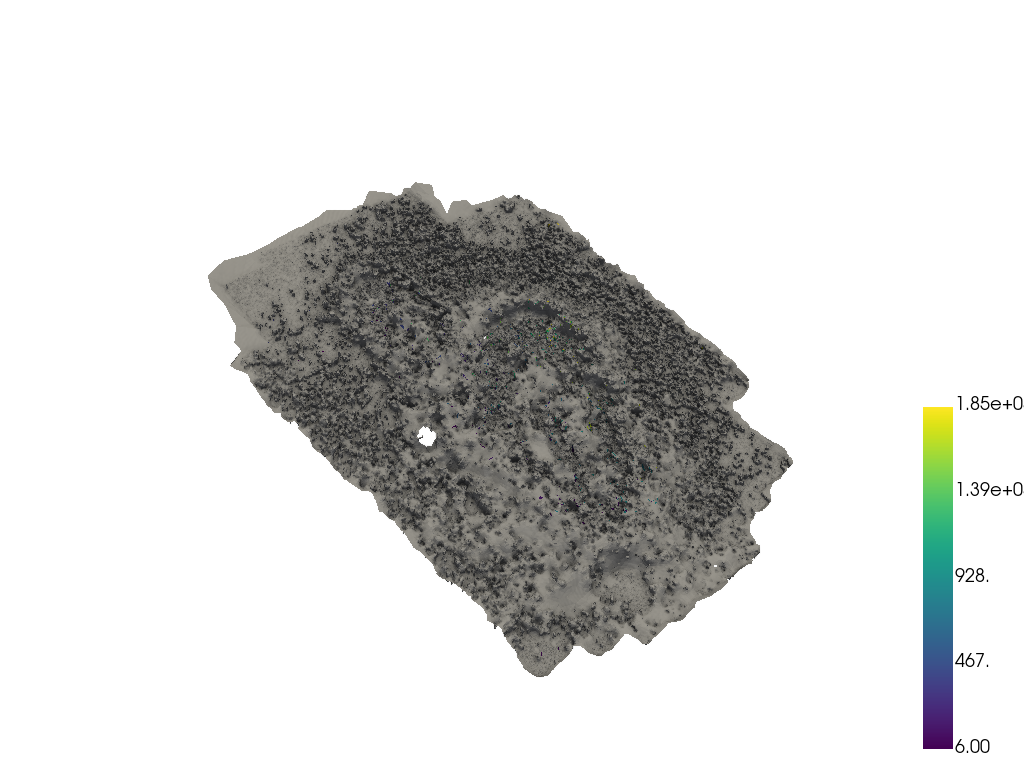

In [3]:
project_detections(
    mesh_filename=MESH_FILENAME,
    cameras_filename=CAMERAS_FILENAME,
    image_folder=IMAGE_FOLDER,
    detections_folder=DETECTIONS_FOLDER,
    projections_to_mesh_filename=PROJECTIONS_TO_MESH_FILENAME,
    projections_to_geospatial_savefilename=PROJECTIONS_TO_GEOSPATIAL_SAVEFILENAME,
    default_focal_length=DEFAULT_FOCAL_LENGTH,
    project_to_mesh=PROJECT_TO_MESH,
    segmentor_kwargs=SEGMENTOR_KWARGS,
    vis_mesh=VIS_MESH,
)

# Convert mesh projections to geospatial
In the previous step, the per-image detections were projected to the mesh. Now, they are converted to a 2D, geospatial representation. This can be visualized and/or exported as desired.

INFO:mesh_129818422115440:Loading transform to EPSG:4326
INFO:mesh_129818422115440:Loading mesh
INFO:mesh_129818422115440:Reading the mesh
INFO:mesh_129818422115440:Selecting an ROI from mesh
INFO:mesh_129818422115440:Extracting faces from mesh
INFO:mesh_129818422115440:Loading texture
INFO:mesh_129818422115440:Computing working CRS
INFO:mesh_129818422115440:Computing faces in working CRS
Converting faces to polygons: 100%|██████████| 13489555/13489555 [03:36<00:00, 62282.68it/s]
INFO:mesh_129818422115440:Creating dataframe of faces
INFO:mesh_129818422115440:Creating dataframe of multipolygons
Merging faces for each class: 100%|██████████| 1822/1822 [03:29<00:00,  8.69it/s]
INFO:mesh_129818422115440:Plotting


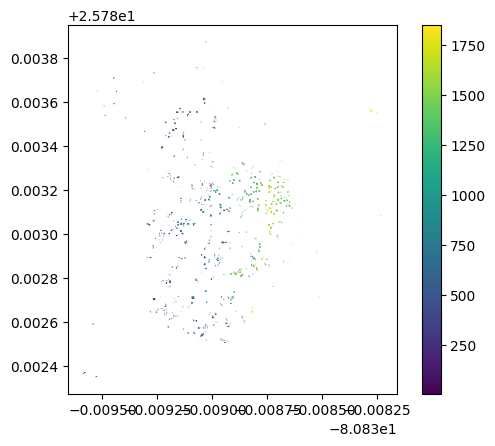

In [4]:
project_detections(
    mesh_filename=MESH_FILENAME,
    cameras_filename=CAMERAS_FILENAME,
    image_folder=IMAGE_FOLDER,
    detections_folder=DETECTIONS_FOLDER,
    projections_to_mesh_filename=PROJECTIONS_TO_MESH_FILENAME,
    projections_to_geospatial_savefilename=PROJECTIONS_TO_GEOSPATIAL_SAVEFILENAME,
    convert_to_geospatial=CONVERT_TO_GEOSPATIAL,
    segmentor_kwargs=SEGMENTOR_KWARGS,
    vis_geodata=VIS_GEODATA,
)

# Show the orthomosaic generated for this site and optionally detections
For assessment, the detections are shown overlaid on the orthomosaic. Both the orthomosaic and exported detections are in geospatial coordinates. 

Columns of projected data: Index(['Unnamed: 0.1', 'xmin', 'ymin', 'xmax', 'ymax', 'label', 'score',
       'image_path', 'instance_ID', 'geometry'],
      dtype='object')


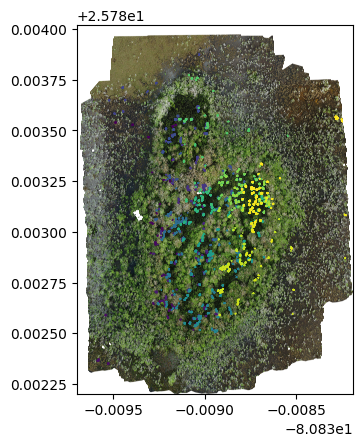

In [5]:
# Read in the orthomosaic
ortho = rio.open(ORTHO_FILENAME)

# Create axes for consistency between the two data products
_, ax = plt.subplots()
# Note this can take a while for large rasters, I'm not sure there's a way to downsample using this function
rio.plot.show(ortho, ax=ax)

# If there are projections, visualize those too
if PROJECTIONS_TO_GEOSPATIAL_SAVEFILENAME is not None and PROJECTIONS_TO_GEOSPATIAL_SAVEFILENAME.exists():
    # Read the file
    projected_detections = gpd.read_file(PROJECTIONS_TO_GEOSPATIAL_SAVEFILENAME)
    # Convert to the same CRS as the ortho
    projected_detections.to_crs(ortho.crs, inplace=True)
    # Print the columns of the projected data
    print(f"Columns of projected data: {projected_detections.columns}")
    # Plot the detections colored by the detection ID
    # This corresponding to their index in the ordered set of all detections
    # Note that this can be colored by any of the columns in the projected data
    projected_detections.plot(INSTANCE_ID_KEY, facecolor="none", ax=ax)

# Alternate approach using triangulation 
This approach does not use the mesh for estimating the 3D locations of the birds. Instead, it casts rays in the direction of the center of each detection. Then, it identifies clusters of pairwise near-intersections between rays as likely locations of birds.

/tmp/ipykernel_2832/3666467030.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image_shape = imread(list(IMAGE_FOLDER.glob("*.JPG"))[0]).shape[:2]
Calculating quality of ray intersections:   0%|          | 0/1851 [00:00<?, ?it/s]/ofo-share/repos-david/geograypher/geograypher/utils/numeric.py:46: RuntimeWarning: invalid value encountered in scalar divide
  a_scaler = (-ab * bc + ac * bb) / denominator
/ofo-share/repos-david/geograypher/geograypher/utils/numeric.py:47: RuntimeWarning: invalid value encountered in scalar divide
  b_scaler = (ab * ac - bc * aa) / denominator
Calculating quality of ray intersections: 100%|██████████| 1851/1851 [00:19<00:00, 94.70it/s] 


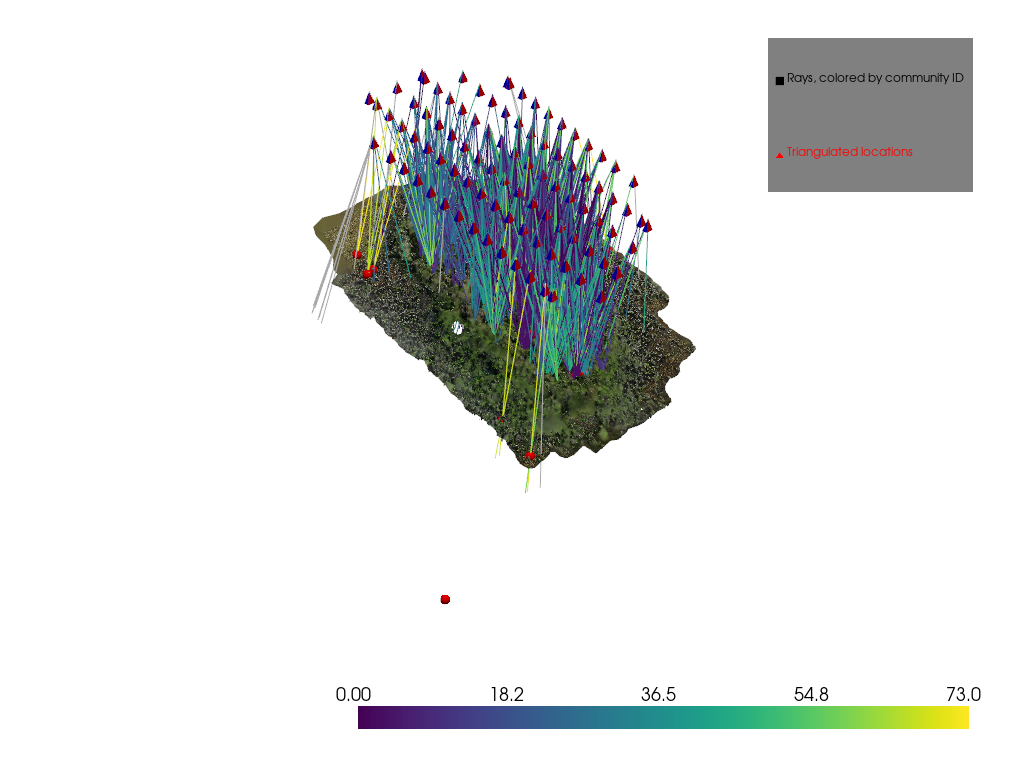

74 birds were detected at the following 3D locations, in (lat, lon, alt) coordinates:
[[ 2.57828477e+01 -8.08388885e+01 -2.81191377e+01]
 [ 2.57830711e+01 -8.08389779e+01 -3.54007819e+01]
 [ 2.57830804e+01 -8.08389717e+01 -2.37892135e+01]
 [ 2.57827201e+01 -8.08390633e+01 -3.40386793e+01]
 [ 2.57832181e+01 -8.08387624e+01 -2.39506008e+01]
 [ 2.57832651e+01 -8.08389606e+01 -3.20294835e+01]
 [ 2.57829325e+01 -8.08389560e+01 -2.26785740e+01]
 [ 2.57830298e+01 -8.08387741e+01 -2.59857189e+01]
 [ 2.57830015e+01 -8.08390813e+01 -3.13038534e+01]
 [ 2.57831039e+01 -8.08389865e+01 -2.80347592e+01]
 [ 2.57829790e+01 -8.08388524e+01 -5.38488765e+01]
 [ 2.57830726e+01 -8.08387847e+01 -4.11770469e+01]
 [ 2.57832160e+01 -8.08388716e+01 -1.13063240e+01]
 [ 2.57829951e+01 -8.08388452e+01 -6.54476202e+01]
 [ 2.57827694e+01 -8.08388784e+01 -4.60382508e+01]
 [ 2.57831583e+01 -8.08388075e+01 -1.76721359e+01]
 [ 2.57832024e+01 -8.08388749e+01 -4.68036432e+01]
 [ 2.57830125e+01 -8.08388001e+01 -2.17094903e+

In [6]:
# Create a set of cameras
camera_set = MetashapeCameraSet(
    camera_file=CAMERAS_FILENAME,
    image_folder=IMAGE_FOLDER,
    default_sensor_params={"cx": 0, "cy": 0, "f": DEFAULT_FOCAL_LENGTH}
)

# Determine the shape of the images, assuming they're all the same
image_shape = imread(list(IMAGE_FOLDER.glob("*.JPG"))[0]).shape[:2]

# Create a detector object that looks up detections from a folder. The predictions should be
# one per image in the DeepForest format.
detector = TabularRectangleSegmentor(
    detection_file_or_folder=DETECTIONS_FOLDER,
    image_folder=IMAGE_FOLDER,
    image_shape=image_shape,
    **SEGMENTOR_KWARGS
)

# Create a pyvista plotter to show both scenes at once
plotter = create_pv_plotter(off_screen=False, force_xvfb=False)

# Load the mesh and plot it
mesh = pv.read(MESH_FILENAME)
plotter.add_mesh(mesh, rgb=True)

# Extract the transform to global coordinates from the cameras filename
transform_to_epsg_4978 = parse_transform_metashape(CAMERAS_FILENAME)

# Identify correspondences between detections and show them
detected_bird_locations = camera_set.triangulate_detections(
    detector=detector,
    transform_to_epsg_4978=transform_to_epsg_4978,
    similarity_threshold_meters=RAY_BASED_SIMILARITY_THRESHOLD_METERS,
    louvain_resolution=LOUVAIN_RESOLUTION,
    plotter=plotter,
    vis_ray_length_meters=VIS_RAY_LENGTH_METERS,
)
# Show the cameras
camera_set.vis(show=True, frustum_scale=0.5, plotter=plotter)

# TODO convert these into geospatial coords
print(f"{len(detected_bird_locations)} birds were detected at the following 3D locations, in (lat, lon, alt) coordinates:\n{detected_bird_locations}")

# Exported the triangulated locations 

In [7]:
# Transform the array to a list of shapely points. Note that the first two coordinates must be
# switched because of different conventions between pyproj and geopandas
points = [Point(l[1], l[0], l[2]) for l in detected_bird_locations]
# Create a dataframe
points_gdf = gpd.GeoDataFrame(geometry=points, crs=LAT_LON_CRS)
# Export the dataframe
points_gdf.to_file(TRIANGULATED_POINTS_SAVEFILE)

# Show the triangulated locations over the ortho

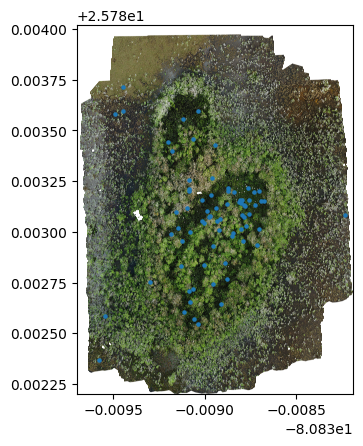

In [8]:
# Read in the orthomosaic
ortho = rio.open(ORTHO_FILENAME)

# Create axes for consistency between the two data products
_, ax = plt.subplots()
# Note this can take a while for large rasters, I'm not sure there's a way to downsample using this function
rio.plot.show(ortho, ax=ax)

# If there are projections, visualize those too
if TRIANGULATED_POINTS_SAVEFILE is not None and TRIANGULATED_POINTS_SAVEFILE.exists():
    # Read the file
    triangulated_detections = gpd.read_file(TRIANGULATED_POINTS_SAVEFILE)
    # Convert to the same CRS as the ortho
    triangulated_detections.to_crs(ortho.crs)
    # Show each triangulated point
    triangulated_detections.plot(markersize=5, ax=ax)